# Experiments with TSP

In [19]:
import os.path

import nest_asyncio
nest_asyncio.apply()

import torch
import torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

from problems.tsp.tsp_env import TSPEnvironment

BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

TSP_DATA_DIR = os.path.join(BASE_PATH, "problems", "tsp", "data", "generated")

TSP_SOLVERS_DIR = os.path.join(BASE_PATH, "problems", "tsp", "minizinc")
TSP_INIT_SOLVER_PATH = os.path.join(TSP_SOLVERS_DIR, "tsp_init.mzn")
TSP_REPAIR_SOLVER_PATH = os.path.join(TSP_SOLVERS_DIR, "tsp_repair.mzn")

problems_paths = [path for path in os.listdir(TSP_DATA_DIR) if path.endswith(".json")]
print(len(problems_paths))

2.3.0
10


In [22]:
env = TSPEnvironment(
    problem_path=os.path.join(TSP_DATA_DIR, problems_paths[0]),
    init_model_path=TSP_INIT_SOLVER_PATH,
    repair_model_path=TSP_REPAIR_SOLVER_PATH,
    solver_name="coinbc",
    max_episode_length=10
)

obs, _ = env.reset()
print(obs)

i = 0
while True:
    print(i)
    obs, _, _, truncated, _ = env.step([1])
    if truncated:
        break
    i += 1

{'problem': {'node_positions': [{'x': 74, 'y': 528}, {'x': 658, 'y': 280}, {'x': 314, 'y': 534}, {'x': 160, 'y': 915}, {'x': 756, 'y': 153}, {'x': 841, 'y': 843}, {'x': 748, 'y': 954}, {'x': 995, 'y': 922}, {'x': 75, 'y': 1}, {'x': 139, 'y': 470}, {'x': 338, 'y': 176}, {'x': 973, 'y': 586}, {'x': 296, 'y': 844}, {'x': 820, 'y': 770}, {'x': 438, 'y': 229}, {'x': 742, 'y': 866}, {'x': 244, 'y': 638}, {'x': 962, 'y': 942}, {'x': 149, 'y': 403}, {'x': 412, 'y': 11}]}, 'solution': {'route': [1, 13, 17, 18, 4, 20, 10, 15, 2, 19, 5, 11, 7, 16, 12, 9, 8, 14, 3, 6]}}
0
1
2
3
4
5
6
7
8
9


In [8]:
def preprocess(observation) -> Data:
    node_positions = observation['problem']['node_positions']
    node_features = torch.tensor([[node['x'], node['y']] for node in node_positions], dtype=torch.float)
    node_positions = node_features.clone()
    
    route = observation['solution']['route']
    edges = []
    for i in range(len(route) - 1):
        # Convert 1-based to 0-based indexing
        src = route[i] - 1
        dst = route[i + 1] - 1
        edges.append((src, dst))
        edges.append((dst, src))
    
    src = route[-1] - 1
    dst = route[0] - 1
    edges.append((src, dst))
    edges.append((dst, src))
    
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    edge_attr = []
    
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, pos=node_positions)
    
graph_data = preprocess(obs)
graph_data

Data(x=[20, 2], edge_index=[2, 40], edge_attr=[0], pos=[20, 2])

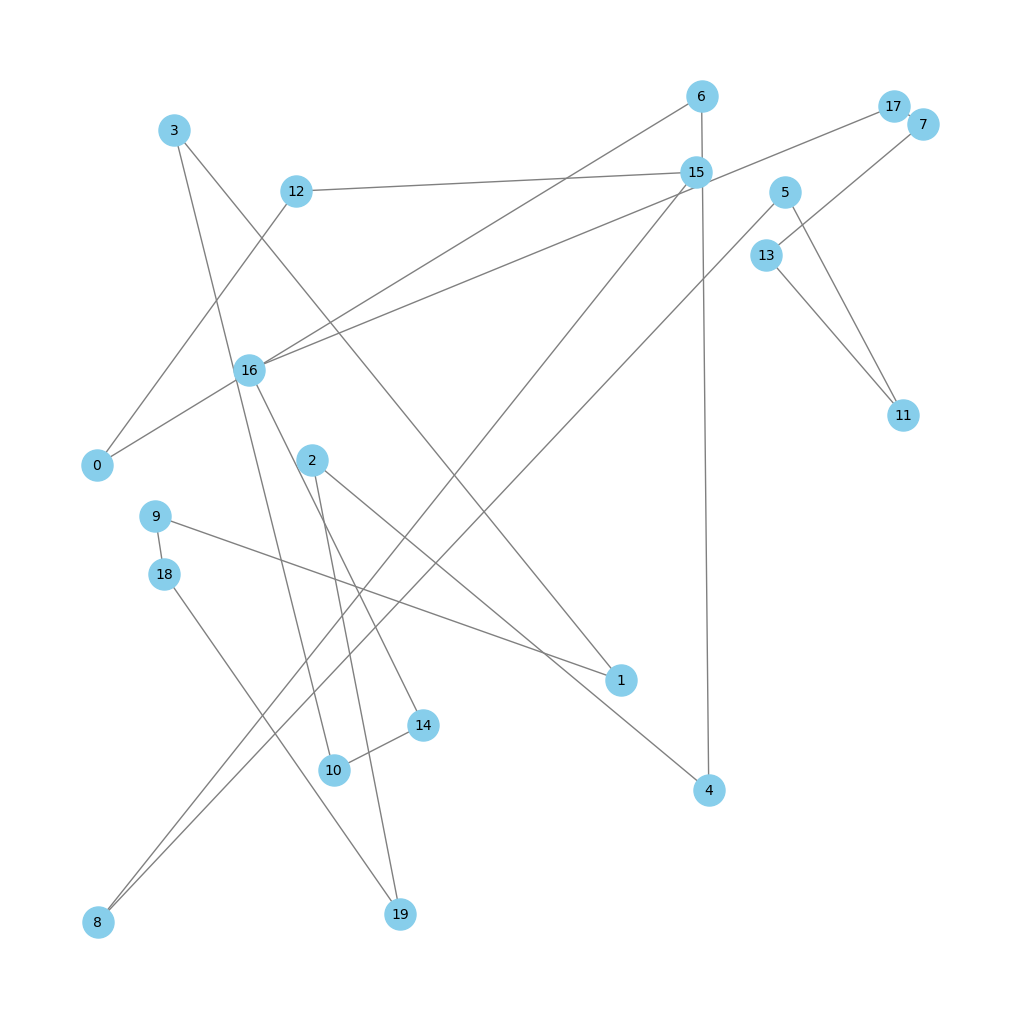

In [10]:
G = pyg.utils.to_networkx(graph_data, node_attrs=['x', 'pos'], to_undirected=True) 

# Extract positions as a dictionary for NetworkX visualization
# NetworkX expects a dictionary {node_id: (x, y)}
fixed_pos = {i: (graph_data.pos[i][0].item(), graph_data.pos[i][1].item()) for i in range(graph_data.pos.size(0))}

plt.figure(figsize=(10, 10))
nx.draw(G, pos=fixed_pos, with_labels=True, node_color="skyblue", node_size=500, edge_color="gray", font_size=10)
plt.show()

In [11]:
graph_data.is_undirected()

True

In [12]:
from torch_geometric.nn import GATConv

class GATDestroyOperator(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.conv2 = GATConv(hidden_channels * num_heads, out_channels, heads=1, concat=False)
        self.fc = nn.Linear(out_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return F.softmax(x, dim=0)

In [15]:
model = GATDestroyOperator(in_channels=2, hidden_channels=8, out_channels=1, num_heads=4)

loader = DataLoader([graph_data], batch_size=1)
for data in loader:
    output = model(data.x, data.edge_index)
    print(output.size())

torch.Size([20, 1])


In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

gamma = 0.99

# Training loop using REINFORCE
for episode in range(1):
    obs, _ = env.reset()
    
    graph_data = preprocess(obs)
    
    log_probs = [] 
    rewards = []
    
    done = False
    while not done:
        node_probs = model(graph_data.x, graph_data.edge_index).squeeze()
        
        num_nodes_to_relax = 3
        selected_nodes = torch.multinomial(node_probs, num_samples=num_nodes_to_relax, replacement=False)
        
        log_prob = torch.log(node_probs[selected_nodes]).sum()
        log_probs.append(log_prob)
        
        action = selected_nodes.tolist()
        print(action)
        obs, reward, terminated, truncated, info = env.step(action)
        
        rewards.append(reward)
        
        done = terminated or truncated
    
    discounted_rewards = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        discounted_rewards.insert(0, R)
    
    policy_loss = []
    for log_prob, reward in zip(log_probs, discounted_rewards):
        policy_loss.append(-log_prob * reward)
    policy_loss = sum(policy_loss)
    
    optimizer.zero_grad()
    policy_loss.backward()
    optimizer.step()
    
    print(f"Episode {episode + 1}, Total Reward: {sum(rewards):.2f}")


[17, 13, 7]
[17, 7, 13]
[17, 13, 7]
[17, 7, 13]
[17, 7, 13]
[17, 7, 13]
[17, 13, 7]
[17, 7, 13]
[17, 13, 7]
[13, 17, 7]
Episode 1, Total Reward: -8.00
